In [41]:
%%bash

pip install pandas numpy gql networkx matplotlib pygraphviz

  Running setup.py install for pygraphviz: started
    Running setup.py install for pygraphviz: finished with status 'done'


You should consider upgrading via the 'pip install --upgrade pip' command.


In [19]:
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
# display full columns
# pd.set_option("display.max_colwidth", 0)

In [4]:
# Use a local server
# GRAPHQL_ENDPOINT = "http://localhost:8080/v1/graphql"

# Use the public endpoint
# !! Please be gentle with your queries! 
# !! This is running on a small postgres server that I'm paying for, so please don't overload it with automated scripts. 
# !! As long as you're running queries by hand through notebooks everything should be fine.
GRAPHQL_ENDPOINT = "http://papergraph.dennybritz.com/v1/graphql"

In [5]:
# create a graphql client

transport = RequestsHTTPTransport(
    url=GRAPHQL_ENDPOINT,
    use_json=True,
    headers={"Content-type": "application/json"},
    verify=False)

client = Client(
    retries=3,
    transport=transport,
    fetch_schema_from_transport=True)

# Query the database

Let's get some data. The following code queries the GraphQL endpoint and gets the 2-level citation graph for a specific paper. It retrieves all papers at most 2 hops away. Assuming each paper on average cites 30 other papers, the result would be 1 + 30 * 30 = ~900 records. Note that the database currently only contains papers labeled as "Computer Science", so cited papers from other fields will not show up.

In [6]:
# Paper title is matched via sql LIKE, so use can use % operators for text matching
PAPER_TITLE = "%Mastering Atari, Go, Chess and Shogi by Planning%"

In [7]:
query = gql("""
fragment paper_fields on papers {
  id
  title
  year
  doi_url
  s2_url
  num_citations
}

query papers($title: String!) {
  papers(limit: 1, where: {title: {_like: $title}}, offset: 0) {
    ...paper_fields
    cites(args: {limit_: 100}) {
      ...paper_fields
      cites(args: {limit_: 100}) {
        ...paper_fields
      }
    }
  }
}
""")

In [8]:
papers = client.execute(query, variable_values={"title": PAPER_TITLE})
root = papers["papers"][0]

In [9]:
def process_recursively(paper, fn):
    """Helper function to process the recursive graph data structure. It runs a function for each element in the graph"""
    fn(paper)
    if not "cites" in paper:
        return
    for cited_paper in paper["cites"]:
        process_recursively(cited_paper, fn)

# Create Graph

Next, let's create a networkx graph object from our data.

In [98]:
g = nx.DiGraph()

In [102]:
def add_nodes_to_graph(paper):
    paper_id = paper["id"]
    if paper_id not in g:
        g.add_node(paper_id, title=paper["title"])
        
def add_edges_to_graph(paper):
    paper_id = paper["id"]
    if not "cites" in paper:
        return
    for cited_paper in paper["cites"]:
        g.add_edge(paper_id, cited_paper["id"])

In [103]:
process_recursively(root, add_nodes_to_graph)
process_recursively(root, add_edges_to_graph)

In [71]:
sg = nx.subgraph_view(g, filter_node=lambda n: g.degree(n) > 5 or n == root["id"])

In [72]:
len(sg)

48

In [80]:
# for n in sg.nodes:
#     print(n)

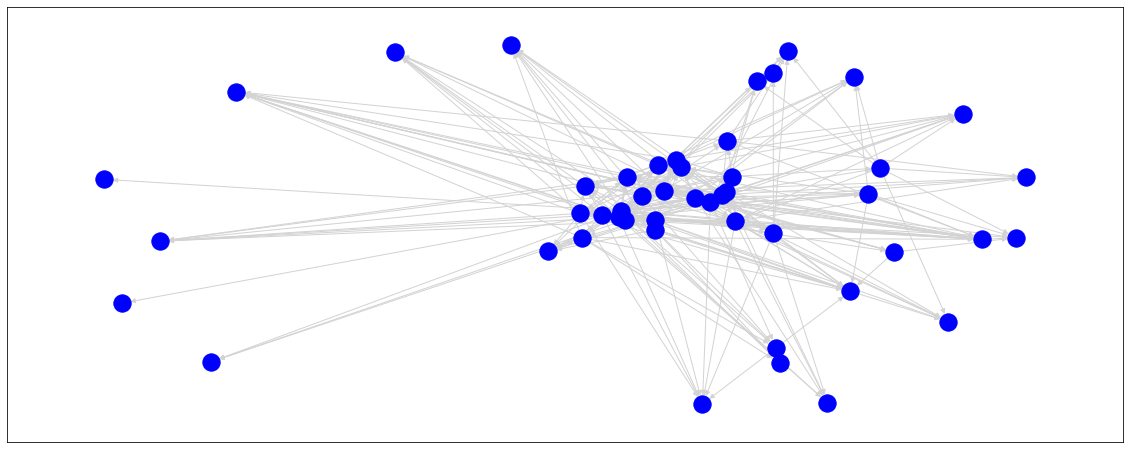

In [88]:
plt.figure(figsize=(20, 8))
node_sizes = [3 + 20 * g.degree(n) for n in sg.nodes]

nx.draw_networkx(sg, with_labels=False, node_sizes=node_sizes, node_color="blue", edge_color="lightgray")

In [109]:
from networkx.readwrite import json_graph
import json
d = json_graph.node_link_data(g) 

In [111]:
with open("graph.json", "w") as f:
    json.dump(d, f)

In [43]:
pos = nx.nx_agraph.graphviz_layout(g)
nx.draw(g, pos=pos)

NameError: name 'G' is not defined

In [ ]:
agg = nx.nx_agraph.to_agraph(g)
agg.layout("circo")

In [49]:
agg.draw("file.png")

KeyboardInterrupt: 